In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

In [2]:
NTURN = [128,256,512,1024,2048]

NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3034496449165134

ChaosPercent = 99.0

npt_Test = 3834

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
print(betx,alfx)

1.9065054393933862 1.4082261727304293


In [5]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [6]:
pData = impact.readParticleData(111110,ke,mass,freq,format_id=2)[npt_Test:,:]
normalize(pData)

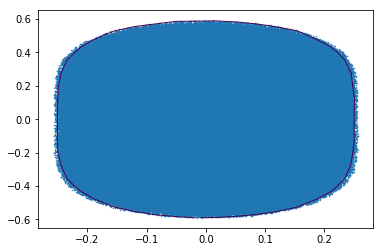

In [7]:
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)

plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,linestyles='solid',levels=[1450])
plt.scatter(pData[:,0],pData[:,2],s=0.2)

In [8]:
iTBT = {}
TBT = {}
X = {}
Y = {}
Npt = {}

for nturn in NTURN:
    print(nturn)
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    TBT[nturn] = TBT[nturn][:,:4,:]
    Npt[nturn] = len(iTBT[nturn])

128
256
512
1024
2048


In [9]:
for i in range(len(NTURN)):
    nturn = NTURN[i]
    
    npt = len(iTBT[nturn])
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    iturn = 0
    for j in range(i+1):
        jturn = NTURN[j]
        
        itmp = np.in1d(iTBT[jturn],iTBT[nturn])
        tmp = TBT[jturn][:,:,itmp]
        X[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(betx*tmp[:,1,:]+alfx*tmp[:,0,:]))/(NL_c*np.sqrt(betx))
        Y[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(betx*tmp[:,3,:]+alfx*tmp[:,2,:]))/(NL_c*np.sqrt(betx))
        print(iturn,jturn,nturn,np.sum(itmp),npt)
        
        iturn = jturn

0 128 128 3527 3527
0 128 256 3482 3482
128 256 256 3482 3482
0 128 512 3395 3395
128 256 512 3395 3395
256 512 512 3395 3395
0 128 1024 3245 3245
128 256 1024 3245 3245
256 512 1024 3245 3245
512 1024 1024 3245 3245
0 128 2048 3067 3067
128 256 2048 3067 3067
256 512 2048 3067 3067
512 1024 2048 3067 3067
1024 2048 2048 3067 3067


### Apply NAFF

In [10]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [11]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}

for nturn in NTURN[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        signal = X[nturn][:int(nturn/2),i] -np.mean(X[nturn][:int(nturn/2),i])
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = X[nturn][int(nturn/2):,i] -np.mean(X[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        
        signal = Y[nturn][:int(nturn/2),i] -np.mean(Y[nturn][:int(nturn/2),i])
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
        signal = Y[nturn][int(nturn/2):,i] -np.mean(Y[nturn][int(nturn/2):,i])
        tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
        
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    Xdiff[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    Ydiff[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

# plot

### FFT

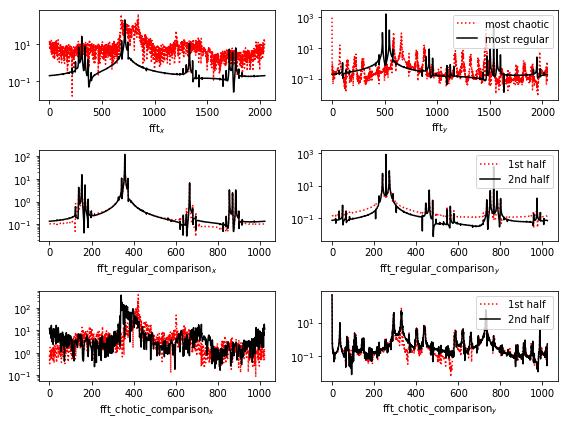

In [12]:
n=NTURN[-1]
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMin[n][1]])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMin[n][2]])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[n][:NTURN[-2],iMin[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][NTURN[-2]:,iMin[n][1]])),'k')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[n][:NTURN[-2],iMin[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][NTURN[-2]:,iMin[n][2]])),'k')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[n][:NTURN[-2],iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][NTURN[-2]:,iMax[n][1]])),'k')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[n][:NTURN[-2],iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][NTURN[-2]:,iMax[n][2]])),'k')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('Realistic.FMA.FFT.png',dpi=180)
# plt.close()

### tune plot

In [13]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

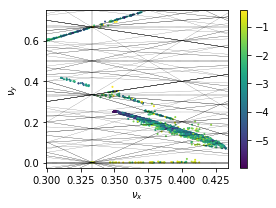

In [14]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=Adiff[n],s=1.0,marker='o')

tmp = np.sort(tuneXbefore[n])
std = 0.2*np.std(tmp)
xmin = tmp[32]-std
xmax = tmp[-32]+std

tmp = np.sort(tuneYbefore[n])
std = 0.2*np.std(tmp)
ymin = tmp[32]-std
ymax = tmp[-32]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('Realistic.FMA.tune.png',dpi=180)
# plt.close()

In [15]:
import scipy

dist = scipy.stats.gaussian_kde(pData[:,[0,2]].transpose())
weight = dist([np.real(X[n][0,:]),np.real(Y[n][0,:])])

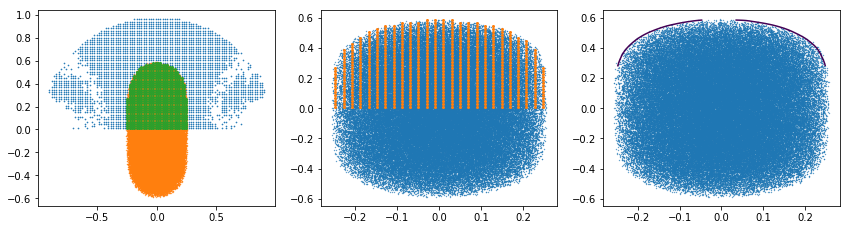

In [16]:
iCore = np.argwhere(weight > 0.2) # empirically found ...
iCore = iTBT[n][iCore]

iCoreTmp = np.in1d(iTBT[n],iCore)
xTmp = np.real(X[n][0,iCoreTmp])
yTmp = np.real(Y[n][0,iCoreTmp])

grid = impact.data.dictClass()
grid.extent = [xTmp.min(),xTmp.max(),yTmp.min(),yTmp.max()]
grid.x, grid.y = np.mgrid[xTmp.min():xTmp.max():64j, yTmp.min():yTmp.max():64j]
grid.points = np.vstack([grid.x.ravel(), grid.y.ravel()])
grid.z = np.reshape(dist(grid.points).T, grid.x.shape)

plt.figure(figsize=(12,3.3))
plt.subplot(1,3,1)
plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),s=0.4)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,2)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,3)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.contour(grid.z.T, extent=grid.extent, levels=[0.2]);
plt.tight_layout()

dist = None
weight = None

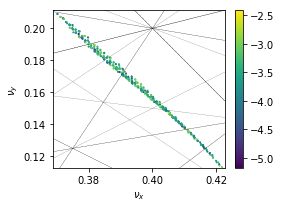

In [17]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.2,ls='--')
f1=plt.scatter(tuneXbefore[n][iCoreTmp],tuneYbefore[n][iCoreTmp],c=Adiff[n][iCoreTmp],s=1.0,marker='o')

tmp = np.sort(tuneXbefore[n][iCoreTmp])
std = 0.2*np.std(tmp)
xmin = tmp[8]-std
xmax = tmp[-8]+std

tmp = np.sort(tuneYbefore[n][iCoreTmp])
std = 0.2*np.std(tmp)
ymin = tmp[8]-std
ymax = tmp[-8]+std

plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.tight_layout()
plt.savefig('Realistic.FMA.tune.core.png',dpi=180)
# plt.close()

### Poincare

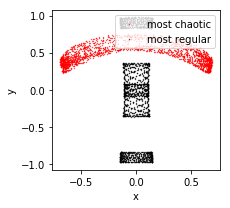

In [18]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('Realistic.FMA.poincare_xy.png',dpi=180)

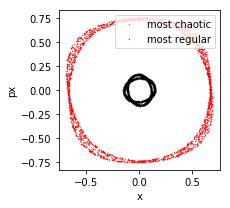

In [19]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('Realistic.FMA.poincare_xpx.png',dpi=180)

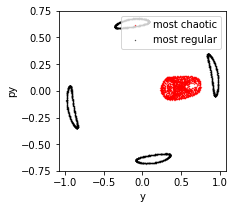

In [20]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('Realistic.FMA.poincare_ypy.png',dpi=180)

### DA

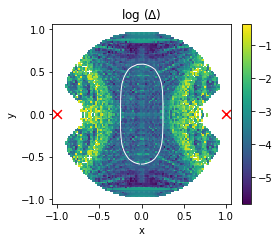

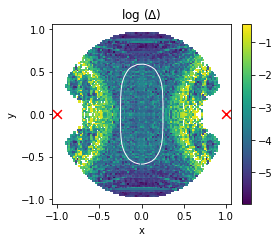

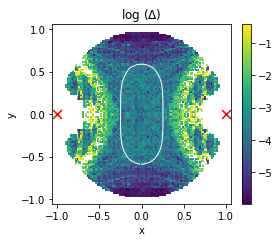

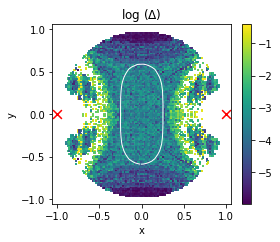

In [21]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in NTURN[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
    plt.scatter(np.real(X[n][0,:]),-np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
    plt.scatter([-1.0,1.0],[0.0,0.0],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[1450])
    plt.savefig('Realistic.FMA.DA.turn='+str(int(n/2))+'.png',dpi=180)